# Training script

### Imports

In [16]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoTokenizer
from transformers import RobertaForTokenClassification
from datasets import load_dataset
from torch import nn
import spacy
import nltk
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_selection import f_classif, SelectKBest
import string
import fasttext
import fasttext.util
from sklearn.svm import SVC
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import normalize
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import seaborn as sns
import os

if not os.path.exists('../cc.en.300.bin'):
    fasttext.util.download_model('en', if_exists='ignore')
embedder = fasttext.load_model('../cc.en.300.bin')
nlp = spacy.load("en_core_web_lg")
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'{device=}')

KeyboardInterrupt: 

### Models

In [30]:
class MLP(nn.Module):
    def __init__(self, input, epochs = 100, batch_size = 64, patience = 2, lr = 1e-3):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.BatchNorm1d(input),
            nn.Linear(input, input),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(input, 100),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.lr = lr
    
    def compute_loss(self, X, y, criterion):
        self.eval()
        batch_size = self.batch_size
        N = X.shape[0]
        batches = [(X[(i - batch_size) : (i if i < N else N - 1), :], y[(i - batch_size) : (i if i < N else N - 1)]) for i in range(batch_size, N + batch_size, batch_size)]
        with torch.no_grad():
            losses = []
            for batch, y_true in batches:
                y_pred = self.forward(batch)
                loss = criterion(y_pred, y_true)
                losses.append(loss.item())
        self.train()
        return np.mean(losses)
    
    def fit(self, X, y, X_val, y_val):
        X = torch.Tensor(X).to(device)
        y = torch.Tensor(y).to(device)
        X_val = torch.Tensor(X_val).to(device)
        y_val = torch.Tensor(y_val).to(device)

        self.head = nn.Linear(50, y.shape[1]).to(device)
        batch_size = self.batch_size
        optim = torch.optim.Adam(self.parameters(), lr = self.lr)
        criterion = nn.BCEWithLogitsLoss()
        N = X.shape[0]
        train_losses = []
        val_losses = []
        waited = 0
        
        for epoch in tqdm(range(self.epochs)):
            batches = [(X[(i - batch_size) : (i if i < N else N - 1), :], y[(i - batch_size) : (i if i < N else N - 1)]) for i in range(batch_size, N + batch_size, batch_size)]
            epoch_train_loss = []
            for batch, y_true in batches:
                y_pred = self.forward(batch)
                loss = criterion(y_pred, y_true)
                optim.zero_grad()
                loss.backward()
                optim.step()
                epoch_train_loss.append(loss.item())
            
            epoch_train_loss = np.mean(epoch_train_loss)
            train_losses.append(epoch_train_loss)
            
            epoch_val_loss = self.compute_loss(X_val, y_val, criterion)
            if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
                waited += 1
                if waited > self.patience:
                    break
            else:
                waited = 0

            val_losses.append(epoch_val_loss)
            
            
        return train_losses, val_losses
    
    def forward(self, X):
        return self.head(self.mlp(X))
    
    def predict(self, X):
        X = torch.Tensor(X).to(device)
        y = self.forward(X)
        return (y > 0.5).float().cpu().detach().numpy()

In [31]:
model = MLP(300).to(device) # Replace model instantiation with another class here (SVC for example) if wishing to test other models
nr_features = 300 # the number of top-scoring features that will be selected ranked by ANOVA score
use_history = False # whether to use the history of the previous sentences


### Loading the dataset

In [32]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_feature_df(dataset):
    act_types = []
    utterance_list = []
    embedding_list = []
    
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        # print(dataset.loc[i].turns['utterance'])
        # print([frame['service'] for frame in dataset.loc[i].turns['frames']])
        for j, (utterance, speaker, dialogue_act) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'])):
            if j == 0:
                prev_user_utterance = ''
                prev_user_acts = []
                prev_bot_utterance = ''
                prev_bot_acts = []
            else:
                prev_user_utterance = turns['utterance'][j - 2]
                prev_user_acts = turns['dialogue_acts'][j - 2]['dialog_act']['act_type']
                prev_bot_utterance = turns['utterance'][j - 1]
                prev_bot_acts = turns['dialogue_acts'][j - 1]['dialog_act']['act_type']
            
            if speaker == 0: # if it's the user's turn
                if use_history:
                    composed_utterance = ' | '.join([prev_user_utterance, ', '.join(prev_user_acts), prev_bot_utterance, ', '.join(prev_bot_acts), utterance])
                else:
                    composed_utterance = utterance
                # print(composed_utterance)
                
                # utterance = composed_utterance.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
                utterance = composed_utterance
                act_type = dialogue_act['dialog_act']['act_type']
                new_utterance = []
                word_embedding_list = []
                
                # doc = nlp(utterance)
                # for token in doc:
                #     new_utterance.append(token.lemma_)
                #     word_embedding_list.append(embedder.get_word_vector(token.lemma_))
                
                # embedding = np.mean(word_embedding_list, axis = 0)
                # print(composed_utterance)
                embedding = embedder.get_sentence_vector(composed_utterance)
                # embedding = np.stack(word_embedding_list)
                
                new_utterance = ' '.join(new_utterance)
                
                embedding_list.append(embedding)
                act_types.append(process_intent_list(act_type))
                utterance_list.append(utterance)
    
    tf_idf = TfidfVectorizer().fit(utterance_list)
                    
    return tf_idf, utterance_list, embedding_list, act_types

In [33]:
dataset = load_dataset('multi_woz_v22')

try:
    train
    print("Dataset already loaded, moving on")
except:
    train = preprocess_split(dataset, 'train')
    test = preprocess_split(dataset, 'test')
    val = preprocess_split(dataset, 'validation')
    tf_idf, train_utterance_list, train_embedding_list, train_act_type = extract_feature_df(train)
    _, test_utterance_list, test_embedding_list, test_act_type = extract_feature_df(test)
    _, val_utterance_list, val_embedding_list, val_act_type = extract_feature_df(test)
    del embedder

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (/Users/pepe/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset already loaded, moving on


(45794, 3575)
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 0 1 0 0 0 0 0]
300 from 3575 features selected


 53%|█████▎    | 53/100 [04:03<03:35,  4.60s/it]


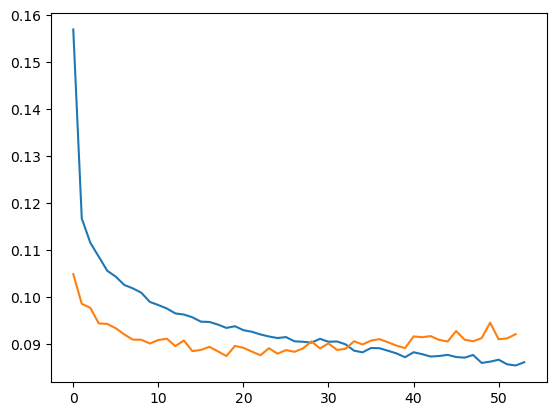

In [34]:
if not isinstance(model, MLP):
    model = MultiOutputClassifier(model)
mlb = MultiLabelBinarizer().fit(train_act_type)

train_tf_idf_feats = tf_idf.transform(train_utterance_list)
train_feats = np.concatenate([train_tf_idf_feats.toarray(), np.stack(train_embedding_list)], axis = 1)
print(train_feats.shape)
# train_feats = np.stack(train_embedding_list) UNCOMMENT TO ONLY USE EMBEDDINGS

train_labels = mlb.transform(train_act_type)
print(train_labels)
print(train_labels[0])
feature_scores = [] 
for i in range(train_labels.shape[1]):
    selector = SelectKBest(f_classif, k='all')
    selector.fit(train_feats, train_labels[:, i])
    feature_scores.append(list(selector.scores_))
feature_scores = np.mean(feature_scores, axis=0)
selected_features = np.argpartition(feature_scores, -nr_features)[-nr_features:]
train_feats_selected = train_feats[:, selected_features]

print(f'{train_feats_selected.shape[1]} from {train_feats.shape[1]} features selected')

val_tf_idf_feats = tf_idf.transform(val_utterance_list)
val_feats = np.concatenate([val_tf_idf_feats.toarray(), np.stack(val_embedding_list)], axis = 1)
val_feats_selected = val_feats[:, selected_features]
val_labels = mlb.transform(val_act_type)

if not isinstance(model, MLP):
    model.fit(train_feats_selected, train_labels)
else:
    train_losses, val_losses = model.fit(train_feats_selected, train_labels, val_feats_selected, val_labels)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.show()
    

In [35]:
test_tf_idf_feats = tf_idf.transform(test_utterance_list)
test_feats = np.concatenate([test_tf_idf_feats.toarray(), np.stack(test_embedding_list)], axis = 1)
# test_feats = np.stack(test_embedding_list) UNCOMMENT TO ONLY USE EMBEDDINGS
test_feats_selected = test_feats[:, selected_features]

if isinstance(model, MLP):
    model.eval()
test_act_type_pred = model.predict(test_feats_selected)

acc = accuracy_score(mlb.transform(test_act_type), test_act_type_pred)
precision, recall, f_score, _ = precision_recall_fscore_support(mlb.transform(test_act_type), test_act_type_pred, average = 'macro')
print(f'acc = {acc}, precision = {precision}, recall = {recall}, f_score = {f_score}')

acc = 0.7700414651002073, precision = 0.923373250287246, recall = 0.6600732771842062, f_score = 0.7376612639059463


In [36]:
report = classification_report(mlb.transform(test_act_type), test_act_type_pred, target_names=mlb.classes_, digits=3)
print(report)

                    precision    recall  f1-score   support

      Hotel-Inform      0.920     0.842     0.879      1328
     Hotel-Request      0.816     0.288     0.425       292
 Restaurant-Inform      0.961     0.769     0.855      1322
Restaurant-Request      0.783     0.164     0.272       286
       general-bye      0.991     0.960     0.975       225
     general-greet      1.000     0.500     0.667         6
     general-thank      0.956     0.965     0.961       693
             other      0.960     0.792     0.868      2039

         micro avg      0.946     0.770     0.849      6191
         macro avg      0.923     0.660     0.738      6191
      weighted avg      0.937     0.770     0.833      6191
       samples avg      0.810     0.796     0.799      6191



/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Save the model
torch.save(model.state_dict(), '01_intent_MLP.pt')